In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/covid_project/dataset.zip -d .

Archive:  /content/drive/MyDrive/covid_project/dataset.zip
   creating: ./dataset/
   creating: ./dataset/covid/
  inflating: ./dataset/covid/image_0_1074.jpg  
  inflating: ./dataset/covid/image_0_1085.jpg  
  inflating: ./dataset/covid/image_0_1255.jpg  
  inflating: ./dataset/covid/image_0_1318.jpg  
  inflating: ./dataset/covid/image_0_1432.jpg  
  inflating: ./dataset/covid/image_0_150.jpg  
  inflating: ./dataset/covid/image_0_1527.jpg  
  inflating: ./dataset/covid/image_0_1602.jpg  
  inflating: ./dataset/covid/image_0_1612.jpg  
  inflating: ./dataset/covid/image_0_1641.jpg  
  inflating: ./dataset/covid/image_0_1757.jpg  
  inflating: ./dataset/covid/image_0_180.jpg  
  inflating: ./dataset/covid/image_0_1855.jpg  
  inflating: ./dataset/covid/image_0_1875.jpg  
  inflating: ./dataset/covid/image_0_1929.jpg  
  inflating: ./dataset/covid/image_0_2012.jpg  
  inflating: ./dataset/covid/image_0_2024.jpg  
  inflating: ./dataset/covid/image_0_2057.jpg  
  inflating: ./dataset/co

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from imutils import paths
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [ ]:
# import the necessary packages
from tensorflow.keras.utils import img_to_array

class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		# store the image data format
		self.dataFormat = dataFormat

	def preprocess(self, image):
		# apply the Keras utility function that correctly rearranges
		# the dimensions of the image
		return img_to_array(image, data_format=self.dataFormat)
  
import imutils
import cv2

class AspectAwarePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# grab the dimensions of the image and then initialize
		# the deltas to use when cropping
		(h, w) = image.shape[:2]
		dW = 0
		dH = 0

		# if the width is smaller than the height, then resize
		# along the width (i.e., the smaller dimension) and then
		# update the deltas to crop the height to the desired
		# dimension
		if w < h:
			image = imutils.resize(image, width=self.width,
				inter=self.inter)
			dH = int((image.shape[0] - self.height) / 2.0)

		# otherwise, the height is smaller than the width so
		# resize along the height and then update the deltas
		# crop along the width
		else:
			image = imutils.resize(image, height=self.height,
				inter=self.inter)
			dW = int((image.shape[1] - self.width) / 2.0)

		# now that our images have been resized, we need to
		# re-grab the width and height, followed by performing
		# the crop
		(h, w) = image.shape[:2]
		image = image[dH:h - dH, dW:w - dW]

		# finally, resize the image to the provided spatial
		# dimensions to ensure our output image is always a fixed
		# size
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

In [ ]:
# import the necessary packages
import numpy as np
import cv2
import os

class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		# store the image preprocessor
		self.preprocessors = preprocessors

		# if the preprocessors are None, initialize them as an
		# empty list
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
		data = []
		labels = []

		# loop over the input images
		for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			label = imagePath.split(os.path.sep)[-2]

			# check to see if our preprocessors are not None
			if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
				for p in self.preprocessors:
					image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
			data.append(image)
			labels.append(label)

			# show an update every `verbose` images
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,
					len(imagePaths)))

		# return a tuple of the data and labels
		return (np.array(data), np.array(labels))

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [ ]:
# grab the list of images that we'll be describing, then extract
# the class label names from the image paths
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

[INFO] loading images...


Preprocessing

In [ ]:
# initialize the image preprocessors
aap = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()

In [ ]:
# load the dataset from disk then scale the raw pixel intensities to
# the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0

In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, random_state=42)

In [ ]:
# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

## Deep Learning (ResNet)

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters, dataset,reg=0.0001, bnEps=2e-5, bnMom=0.9):
		
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# check if we are utilizing the CIFAR dataset
		if dataset == "cifar":
			# apply a single CONV layer
			x = Conv2D(filters[0], (3, 3), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)

		# check to see if we are using the Tiny ImageNet dataset
		elif dataset == "dataset1":
			# apply CONV => BN => ACT => POOL to reduce spatial size
			x = Conv2D(filters[0], (5, 5), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)
			x = BatchNormalization(axis=chanDim, epsilon=bnEps,
				momentum=bnMom)(x)
			x = Activation("relu")(x)
			x = ZeroPadding2D((1, 1))(x)
			x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

In [ ]:
model = ResNet.build(64, 64, 3, 3,(3, 4, 6),
		(64, 128, 256, 512),"dataset")

In [ ]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


checkpoint_filepath='/content/drive/MyDrive/covid_project/resnet_weight.h5'
checkpointer = ModelCheckpoint(checkpoint_filepath, verbose=1, save_best_only=True, monitor='val_accuracy')

print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=32),
	validation_data=(testX, testY), epochs=10,
	steps_per_epoch=len(trainX) // 32, verbose=1,callbacks = [checkpointer])

# evaluate the network on the fine-tuned model
print("[INFO] evaluating after fine-tuning...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=classNames))

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 1.4122 - accuracy: 0.5874 
Epoch 1: val_accuracy improved from -inf to 0.48113, saving model to /content/drive/MyDrive/covid_project/resnet_weight.h5
9/9 [==============================] - 121s 12s/step - loss: 1.4122 - accuracy: 0.5874 - val_loss: 1.5210 - val_accuracy: 0.4811
Epoch 2/10
9/9 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.8671 
Epoch 2: val_accuracy did not improve from 0.48113
9/9 [==============================] - 103s 12s/step - loss: 0.9891 - accuracy: 0.8671 - val_loss: 1.6888 - val_accuracy: 0.3868
Epoch 3/10
9/9 [==============================] - ETA: 0s - loss: 0.8930 - accuracy: 0.8811
Epoch 3: val_accuracy did not improve from 0.48113
9/9 [==============================] - 97s 11s/step - loss: 0.8930 - accuracy: 0.8811 - val_loss: 2.3789 - val_accuracy: 0.3868
Epoch 4/10
9/9 [==============================] - ETA: 0s - l

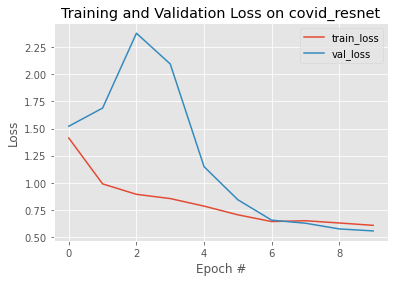

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss on covid_resnet")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

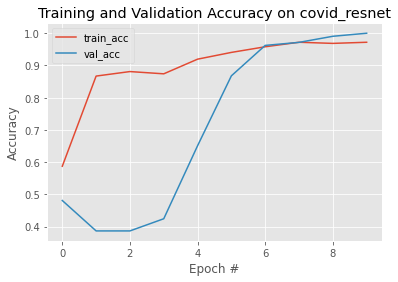

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy on covid_resnet")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

## Prediction

In [ ]:
!pip install pyngrok
!pip install flask-ngrok
!pip install flask-cors==3.0.7
!ngrok authtoken 24jMmkCh5Tr4hOZ9Dpg69QtTDSH_3n21SSxtBHr1F9QckcBzi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask
from flask import Flask, app,request
import json
import sys
import pandas as pd
from flask import jsonify
# import requests
from datetime import datetime
from base64 import b64decode
from flask_cors import CORS, cross_origin
from keras.models import load_model
import tensorflow as tf

app = Flask(__name__)
cors = CORS(app)
run_with_ngrok(app)   #starts ngrok when the app is run
@app.route('/covid', methods=['GET','POST'])
# @cross_origin()
def login():

    result = input(request.json['uri'])
    return result

def input(uri):

    print("[INFO] loading model...")
    print(uri)
    image_url = uri
    image_extension = image_url[-4:]
    image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)


    image = cv2.imread(image_path)
    data = aap.preprocess(image)
    data = data.astype("float") / 255.0
    data = np.expand_dims(data, axis=0)
    model_weight = load_model("/content/drive/MyDrive/covid_project/resnet_weight.h5")
    preds = model_weight.predict(data)
    label = classNames[preds.argmax()].upper()

    return ({"data":str(label)})

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://04b9-34-91-61-195.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [20/Mar/2023 11:17:24] "OPTIONS /covid HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Mar/2023 11:17:24] "OPTIONS /covid HTTP/1.1" 200 -


[INFO] loading model...
https://infura-ipfs.io/ipfs/QmTAZKgFAucQh4uPjWdCGfWAzxM7SBDPrTVfDmZABXDkH3
120368/120368 [==============================] - 0s 0us/step


ERROR:__main__:Exception on /covid [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/flask/app.py", line 2528, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.9/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.9/dist-packages/flask_cors/extension.py", line 161, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.9/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.9/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "<ipython-input-45-93800620d18a>", line 22, in login
    result = input(request.json['uri'])
KeyError: 'uri'
INFO:werkzeug:127.0.0.1 - - [20/Mar/2023 11:17:25] "POST /covid HTTP

1/1 [==============================] - 1s 781ms/step


INFO:werkzeug:127.0.0.1 - - [20/Mar/2023 11:17:28] "POST /covid HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Mar/2023 11:21:12] "OPTIONS /covid HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Mar/2023 11:21:12] "OPTIONS /covid HTTP/1.1" 200 -
ERROR:__main__:Exception on /covid [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/flask/app.py", line 2528, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.9/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.9/dist-packages/flask_cors/extension.py", line 161, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.9/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.9/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self

[INFO] loading model...
https://infura-ipfs.io/ipfs/QmUr6NhkWTFJ3tAX46nTkdc1UV9mhYVuNMxer6s71RNQyH
1/1 [==============================] - 1s 856ms/step


INFO:werkzeug:127.0.0.1 - - [20/Mar/2023 11:21:17] "POST /covid HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Mar/2023 12:35:52] "OPTIONS /covid HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Mar/2023 12:35:52] "OPTIONS /covid HTTP/1.1" 200 -


[INFO] loading model...
https://infura-ipfs.io/ipfs/QmcLLNXq7bBeFLNm6ajepYTVp7rfJgQJPTfBrUvZXgf2fU
[INFO] loading model...
https://infura-ipfs.io/ipfs/QmfLi7A8XFo1wQmQ2DUvj1KH6i8toDiDTqy7z5H4pddGCG
1/1 [==============================] - 1s 1s/step


INFO:werkzeug:127.0.0.1 - - [20/Mar/2023 12:35:56] "POST /covid HTTP/1.1" 200 -


1/1 [==============================] - 1s 786ms/step


INFO:werkzeug:127.0.0.1 - - [20/Mar/2023 12:36:29] "POST /covid HTTP/1.1" 200 -
